---
title: "Sentiment Analysis"
---

# Overview

One of our main data science questions relates to public opinion regarding cannabis and psychosis. Specifically, these three research questions remain unaddressed in previous sections of our research:
* What is the public sentiment regarding cannabis?
* Does public sentiment indicate an awareness of the dangers of cannabis, especially as related to psychosis?
* What is the public sentiment regarding cannabinoids such as CBD and THC products?

To answer these questions, we will perform sentiment analysis on the three subreddits we have been analyzing: r/Psychosis, r/schizophrenia, and r/weed. In this analysis, our main goal is to first determine whether the post mentions cannabis, psychosis, or both. We will then use a Large Language Model to determine the attitude of the post towards cannabis and psychosis.

# Data Preparation

Since we are using a Large Language Model, we will need to use our original dataset. In the cleaning process, we removed stopwords, numbers, and other non-essential words. However, in order for an LLM to work well, we actually want to keep every word in the post. These words provide context for the LLM to model the relationships between words in the text. 

In [5]:
import pandas as pd
import json

with open("../../data/raw_data/reddit_psychosis_data.json") as f:
    reddit_psychosis = json.load(f)
with open('../../data/raw_data/reddit_cannabis_data.json') as f:
    reddit_cannabis = json.load(f)
with open("../../data/raw_data/reddit_schizophrenia_data.json") as f:
    reddit_schizophrenia = json.load(f)

In [6]:
def parse_reddit_json(reddit_json):
    text_list = []
    title_list = []
    subreddit_list = []
    for i in range(0, 100):
        index = str(i)
        for j in range(0, 100):
            text_list.append(reddit_json[index]['data']['children'][j]['data']['selftext'])
            title_list.append(reddit_json[index]['data']['children'][j]['data']['title'])
            subreddit_list.append(reddit_json[index]['data']['children'][j]['data']['subreddit'])

    return text_list, title_list, subreddit_list

psy_text, psy_title, psy_sub = parse_reddit_json(reddit_psychosis)
schiz_text, schiz_title, schiz_sub = parse_reddit_json(reddit_schizophrenia)
cannabis_text, cannabis_title, cannabis_sub = parse_reddit_json(reddit_cannabis)

text = psy_text + schiz_text + cannabis_text
title = psy_title + schiz_title + cannabis_title
sub = psy_sub + schiz_sub + cannabis_sub

reddit_df = pd.DataFrame({'text': text, 'title': title, 'subreddit': sub})

In [7]:
reddit_df['full_text'] = reddit_df['title'] + ' ' + reddit_df['text']

In [36]:
reddit_df.drop_duplicates(subset='full_text', inplace=True)

Now that we have our original dataset, we will need to create a new column that indicates whether the post mentions cannabis, psychosis, or both. We will use a list of keywords linked to cannabis and psychosis to determine whether the post mentions either of these topics. We will create a new column indicating whether each post mentions cannabis, psychosis, or both.

In [37]:
cannabis_words = ['cannabis', 'weed', 'marijuana', '420', 'blunt', 'joint', 'high', 'stoned', 'smoke', 'smoking', '😮‍💨']
schiz_words = ['schizophrenia', 'schizo', 'schizoaffective', 'schizotypal', 'schizoid', 'schiz', 'hallucination', 'delusion', 'psychosis', 'psychotic']

def label_subreddit_cannabis(text):
    for word in cannabis_words:
        if word in text:
            return True
    return False

def label_subreddit_schiz(text):
    for word in schiz_words:
        if word in text:
            return True
    return False

reddit_df['cannabis'] = reddit_df['full_text'].apply(label_subreddit_cannabis)
reddit_df['schiz'] = reddit_df['full_text'].apply(label_subreddit_schiz)

In [38]:
def label_subreddit(text):
    if label_subreddit_cannabis(text) and label_subreddit_schiz(text):
        return 'both'
    elif label_subreddit_schiz(text):
        return 'psychosis'
    elif label_subreddit_cannabis(text):
        return 'cannabis'
    else:
        return 'neither'
    
reddit_df['label'] = reddit_df['full_text'].apply(label_subreddit)

In [39]:
print(reddit_df['label'].value_counts())
print(reddit_df['label'].value_counts(normalize=True))

label
neither      195
psychosis     61
cannabis      36
both           7
Name: count, dtype: int64
label
neither      0.652174
psychosis    0.204013
cannabis     0.120401
both         0.023411
Name: proportion, dtype: float64


Text(0, 0.5, 'Number of Reddit Posts')

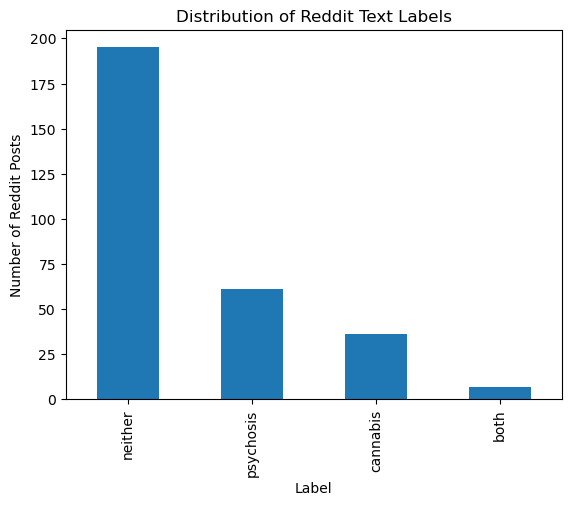

In [40]:
from matplotlib import pyplot as plt

reddit_df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Reddit Text Labels')
plt.xlabel('Label')
plt.ylabel('Number of Reddit Posts')

In [41]:
reddit_df[reddit_df['label'] == 'both'][['full_text', 'label']].head(10)

,full_text,label
21,NEVER smoke weed if you experience psychosis I...,both
33,My little brother jumped of the 12th floor dur...,both
53,I had chronic psychosis for over 7 months and ...,both
55,Weed can be dangerous too guys Went to have a ...,both
69,I ruined my entire life and I’m only 23 I don’...,both
93,I stabbed my friend in Psychosis Already spent...,both
10053,Schizophrenics labeled “Karens” I keep seeing ...,both


We see that the majority of posts (65%) do not mention cannabis or psychosis. On the other end of the spectrum, 2% of posts mention both cannabis and psychosis. The remaining 33% of posts mention either cannabis or psychosis, with psychosis being mentioned more often than cannabis.

# Sentiment Analysis

Now that we have labeled data, we want to perform sentiment analysis on the text. We are specifically interested in the sentiment of text that mentions both cannabis and psychosis, but we will analyze all the text data because samples that mention both are very limited.

To perform sentiment analysis, we will use the `txtai` library. We use `sentence-transformers/nli-mpnet-base-v2`, a high-quality, open source model for our sentence embeddings. Then, we use `distilbert-base-uncased-finetuned-sst-2-english` to perform sentiment analysis on the sentence embeddings. Both of these models are pre-trained on large datasets, so we can use transfer learning to apply them to our data. They are relatively light-weight and have high accuracy, so they are ideal for our purposes.

In [47]:
from transformers import pipeline
from txtai.embeddings import Embeddings

sentiment_analyzer = pipeline("sentiment-analysis")
embeddings = Embeddings(path="sentence-transformers/nli-mpnet-base-v2")

text = "I love using txtai for natural language processing!"

sentiment_result = sentiment_analyzer(text)[0]
print(f"Sentiment: {sentiment_result['label']} (confidence: {sentiment_result['score']:.2f})")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Sentiment: POSITIVE (confidence: 1.00)


In [49]:
for index, row in reddit_df.iterrows():
    text = row['full_text']
    if len(text) > 512:
        text = text[:512]
    # Get the sentiment for the text
    sentiment_result = sentiment_analyzer(text)[0]
    reddit_df.loc[index, 'sentiment'] = sentiment_result['label']
    reddit_df.loc[index, 'sentiment_confidence'] = sentiment_result['score']

# Results

In [50]:
reddit_df

,text,title,subreddit,full_text,cannabis,schiz,label,sentiment,sentiment_confidence
0,3 years post-psychosis in recovery some days c...,first time smiling on camera in... 3 years!,Psychosis,first time smiling on camera in... 3 years! 3 ...,False,True,psychosis,POSITIVE,0.996600
1,,I quit my meds lmfao,Psychosis,I quit my meds lmfao,False,False,neither,NEGATIVE,0.999569
2,,I hate it here,Psychosis,I hate it here,False,False,neither,NEGATIVE,0.999582
3,,art by me. I thought it kinda visualized how I...,Psychosis,art by me. I thought it kinda visualized how I...,False,False,neither,POSITIVE,0.990578
4,,But I’m still god and this is neither a joke a...,Psychosis,But I’m still god and this is neither a joke a...,False,True,psychosis,POSITIVE,0.996085
...,...,...,...,...,...,...,...,...,...
20095,,*sigh* Everything reminds me of her...,weed,*sigh* Everything reminds me of her...,False,False,neither,POSITIVE,0.999636
20096,,r/nevertellmetheodds,weed,r/nevertellmetheodds,False,False,neither,NEGATIVE,0.950680
20097,,I smoked weed in her basement 😮‍💨,weed,I smoked weed in her basement 😮‍💨,True,False,cannabis,NEGATIVE,0.995856
20098,,smoke what?,weed,smoke what?,True,False,cannabis,NEGATIVE,0.993274


Text(0, 0.5, 'Number of Reddit Posts')

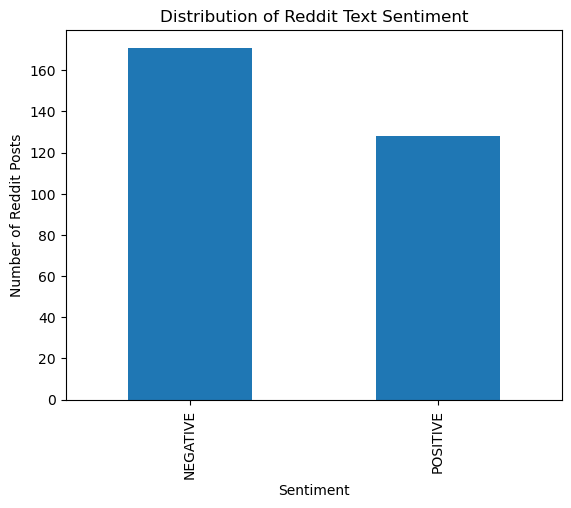

In [52]:
reddit_df['sentiment'].value_counts().plot(kind='bar')
plt.title('Distribution of Reddit Text Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reddit Posts')

Text(0.5, 0, 'Sentiment Confidence')

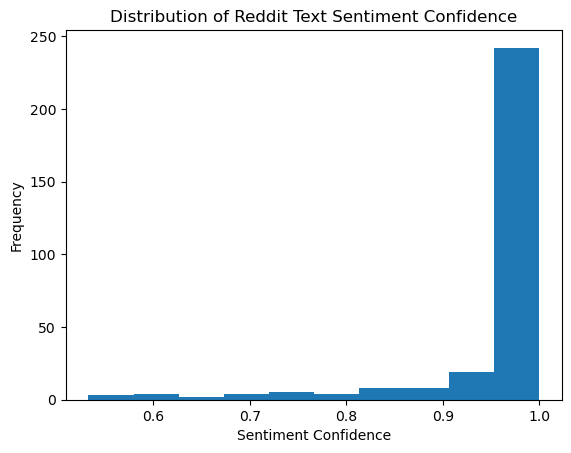

In [53]:
reddit_df['sentiment_confidence'].plot(kind='hist')
plt.title('Distribution of Reddit Text Sentiment Confidence')
plt.xlabel('Sentiment Confidence')

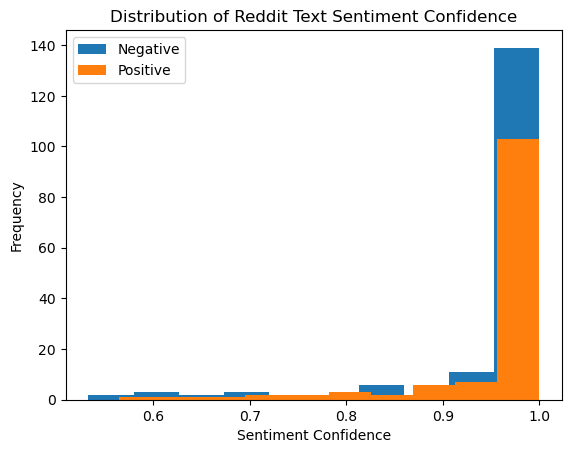

In [58]:
# Visualize the distribution of sentiment confidence for each sentiment
reddit_df[reddit_df['sentiment'] == 'NEGATIVE']['sentiment_confidence'].plot(kind='hist')
reddit_df[reddit_df['sentiment'] == 'POSITIVE']['sentiment_confidence'].plot(kind='hist')
plt.title('Distribution of Reddit Text Sentiment Confidence')
plt.xlabel('Sentiment Confidence')
plt.legend(['Negative', 'Positive'])
plt.show()

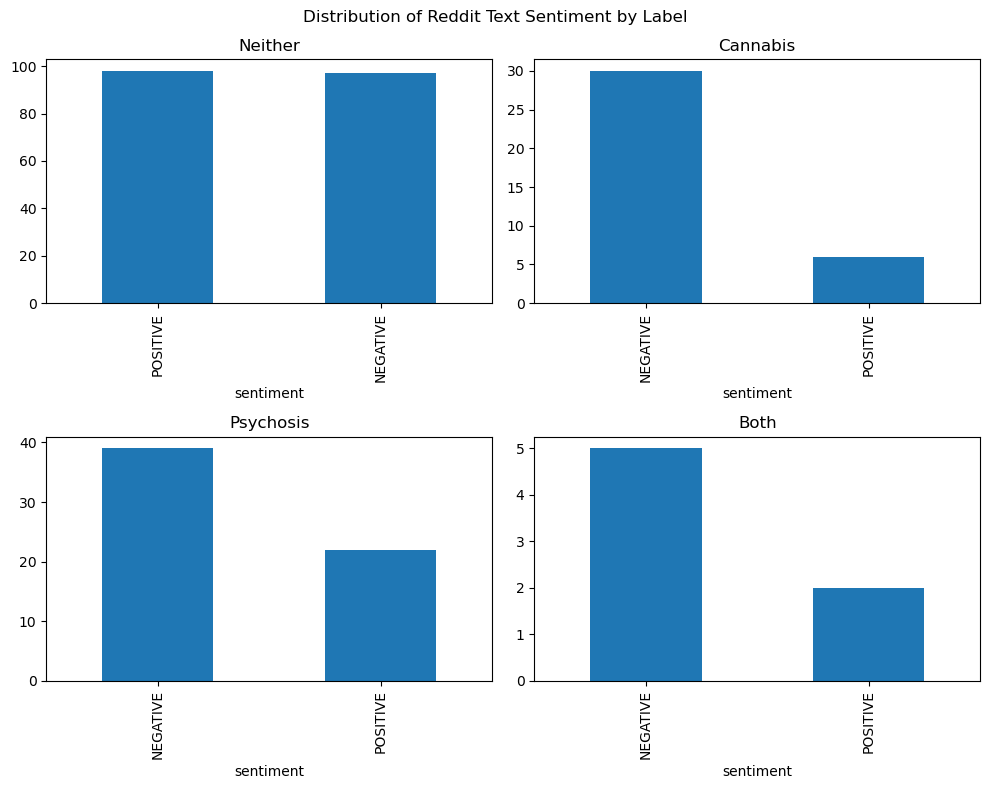

In [65]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].set_title('Neither')
reddit_df[reddit_df['label'] == 'neither']['sentiment'].value_counts().plot(kind='bar', ax=axs[0, 0])

axs[0, 1].set_title('Cannabis')
reddit_df[reddit_df['label'] == 'cannabis']['sentiment'].value_counts().plot(kind='bar', ax=axs[0, 1])

axs[1, 0].set_title('Psychosis')
reddit_df[reddit_df['label'] == 'psychosis']['sentiment'].value_counts().plot(kind='bar', ax=axs[1, 0])

axs[1, 1].set_title('Both')
reddit_df[reddit_df['label'] == 'both']['sentiment'].value_counts().plot(kind='bar', ax=axs[1, 1])

fig.suptitle('Distribution of Reddit Text Sentiment by Label')
plt.tight_layout()
plt.show()

Through visualization, it appears that the sentiment of text is more negative for posts that mention psychosis and/or cannabis than for posts that do not. It also appears that the sentiment of text is more negative for posts that mention cannabis than for posts that mention psychosis. In order to test these hypotheses, we will perform a chi-squared tests.

## Chi-Squared Test

In [92]:
# chi squared test
from scipy.stats import chi2_contingency
from scipy.stats import chi2

contingency_table = pd.crosstab(reddit_df['label'], reddit_df['sentiment'])
print("Observed values:\n-----------------")
print(contingency_table)
print()

stat, p, dof, expected = chi2_contingency(contingency_table)
print("Expected values:\n-----------------")
contingency_table = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)
print(contingency_table)
print()

print(f"Chi-squared statistic: {stat}")
print(f"p-value: {p}")

Observed values:
-----------------
sentiment  NEGATIVE  POSITIVE
label                        
both              5         2
cannabis         30         6
neither          97        98
psychosis        39        22

Expected values:
-----------------
sentiment    NEGATIVE   POSITIVE
label                           
both         4.003344   2.996656
cannabis    20.588629  15.411371
neither    111.521739  83.478261
psychosis   34.886288  26.113712

Chi-squared statistic: 16.179221113176837
p-value: 0.0010419638850492738
